# Benchmark Sentence Transformers

# Introduction

In this tutorial, we will show how you can use `octoml-profile` to quickly benchmark different SentenceTransformers on various hardware software backend.

In [1]:
import pandas as pd
import os
import sys
import torch

from collections import namedtuple
from sentence_transformers import SentenceTransformer, util
from typing import List
from octoml_profile import accelerate, remote_profile, RemoteInferenceSession
from octoml_profile.report import ProfileReport

## Step 1: Set the necessary environment variables

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
# os.environ['OCTOML_PROFILE_API_TOKEN'] = "REPLACE ME"

## Step 2: Define what API we want to measure

This is the API we are interested in benchmarking. It takes a list of query strings, and a precomputed corpus embeddings, returns the topk similar document per query string, and their score.

The magic `accelerate` decorator will be used later to run and benchmark tensor programs remotely.

In [3]:
@accelerate
def semantic_search(model, queries: List[str], corpus_embeddings: List[torch.Tensor], topk: int):
    """Example from https://www.sbert.net/examples/applications/semantic-search/README.html
    """
    topk = min(topk, len(corpus))
    query_embedding = model.encode(queries, convert_to_tensor=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)
    topk_scores, topk_index = torch.topk(cos_scores, k=topk, dim=-1)
    return (topk_scores, topk_index)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [4]:
def run_model(model_id: str, queries: List[str], corpus: List[str]):
    print("======================")
    print("Model:", model_id)
    model = SentenceTransformer(model_id)
    corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

    # run two times and the initial run with compilation will be discarded
    for _ in range(2):
        scores, indices = semantic_search(model, queries, corpus_embeddings, topk=5)
    for query_id, query in enumerate(queries):
        print("\nQuery:", query)
        print("Top 5 most similar sentences in corpus:")
        for score, doc_id in zip(scores[query_id], indices[query_id]):
            print(corpus[doc_id], "(Score: {:.4f})".format(score))
    print("======================\n\n")

## Step 3: Prepare Remote Benchmark Code

To run the same code above but on remote hardware/software backend, we simply need to wrap the `run_model` with a `RemoteInferenceSession` and `remote_profile` context manager.

In [5]:
BenchmarkRecord = namedtuple('Record', ['model', 'backend', 'time_ms', 'cost_per_mreq', 'batch_size'])

In [6]:
def remote_benchmark(model_id, queries, corpus, batch_size, backends=None, verbose=True) -> List[BenchmarkRecord]:
    session = RemoteInferenceSession(backends=backends)
    
    # Fill batches queries from repeatedly adding queries up to length batch_size
    q, r = divmod(batch_size, len(queries))
    batched_queries =  q * queries + queries[:r]

    with session.as_default():
        with remote_profile(print_results_to=sys.stdout if verbose else None) as r:
            run_model(model_id, batched_queries, corpus)
            return parse_report(model_id, r.report(), batch_size)

In [7]:
def parse_report(model_id, report: ProfileReport, batch_size) -> List[BenchmarkRecord]:
    """Helper function to parse the profiling report
    """
    records = []
    hw_cost = {
        'r6i.large': 0.126,
        'r7g.large': 0.107,
        'g4dn.xlarge': 0.526,
        'g5.xlarge': 1.006
    }
    assert len(report.profiles) == 1
    uncompiled_code_ms = report.profiles[0].total_uncompiled_ms
    report.profiles[0].print()
    for backend, result in report.profiles[0].total_per_backend.items():
        if len(result.errors) > 0:
            message = "\n".join(result.errors)
            raise RuntimeError(f"Error in running {model_id} on {backend}: {message}")
        total_time_ms = uncompiled_code_ms + result.estimated_total_ms
        cost_per_hr = hw_cost[backend.split("/")[0]]
        cost_per_mreq = cost_per_hr * (1e6 * total_time_ms / (3600 * 1000))
        records.append(BenchmarkRecord(model_id, backend, total_time_ms, cost_per_mreq, batch_size))
    return records


### Step 4: Set the data and try remote benchmark with one model

In [8]:
queries = ['A man is eating pasta.',
           'Someone in a gorilla costume is playing a set of drums.',
           'A cheetah chases prey on across a field.']

corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]

### Step 5: Let's evaluate on many models and many backends

In [9]:
# Models can be found from: https://www.sbert.net/docs/pretrained_models.html
model_ids = ['all-MiniLM-L12-v2',
             'all-MiniLM-L6-v2',
             'all-distilroberta-v1',
             'paraphrase-albert-small-v2',
             'paraphrase-MiniLM-L3-v2',
             ]
# Backends can be found from `session.supported_backends()`
backends = ['r6i.large/onnxrt-cpu',
            'r6i.large/torch-eager-cpu',
            'r7g.large/onnxrt-cpu',
            'g4dn.xlarge/onnxrt-cuda',
            'g4dn.xlarge/onnxrt-tensorrt',
            'g4dn.xlarge/torch-eager-cuda',
            'g4dn.xlarge/torch-inductor-cuda',
            ]

In [10]:
def benchmark_all(model_ids, backends, output_file, batch_size):
    records = []
    for model_id in model_ids:
        results = remote_benchmark(model_id,
                                   queries,
                                   corpus,
                                   batch_size,
                                   backends=backends,
                                   verbose=False)
        records.extend(results)
    return records

In [11]:
%%capture
result_file = 'sentence_transformer_eval_with_torch.csv'
if not os.path.exists(result_file):
    records = benchmark_all(model_ids, backends, result_file, 1)
    records256 = benchmark_all(model_ids, backends, result_file, 256)

    df = pd.DataFrame(data=records + records256)
    df.to_csv(result_file)

## Step 6: Analyze the result

In [12]:
df = pd.read_csv(result_file, index_col=0)
# Rename here for more informative label display, altair does not
# properly display `alt.X` in github.
df.rename(columns={'cost_per_mreq': 'dollar_cost_per_million_requests'}, inplace=True)

with pd.option_context('display.width', 120):
    print (df)

                      model                          backend     time_ms  dollar_cost_per_million_requests  batch_size
0         all-MiniLM-L12-v2             r6i.large/onnxrt-cpu   17.820951                          0.623733           1
1         all-MiniLM-L12-v2        r6i.large/torch-eager-cpu   28.495958                          0.997359           1
2         all-MiniLM-L12-v2             r7g.large/onnxrt-cpu   21.257491                          0.135812           1
3         all-MiniLM-L12-v2          g4dn.xlarge/onnxrt-cuda   11.897796                          1.738400           1
4         all-MiniLM-L12-v2      g4dn.xlarge/onnxrt-tensorrt   12.402284                          1.812111           1
..                      ...                              ...         ...                               ...         ...
65  paraphrase-MiniLM-L3-v2             r7g.large/onnxrt-cpu  872.684674                          5.575485         256
66  paraphrase-MiniLM-L3-v2          g4dn.xlarge

In [13]:
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

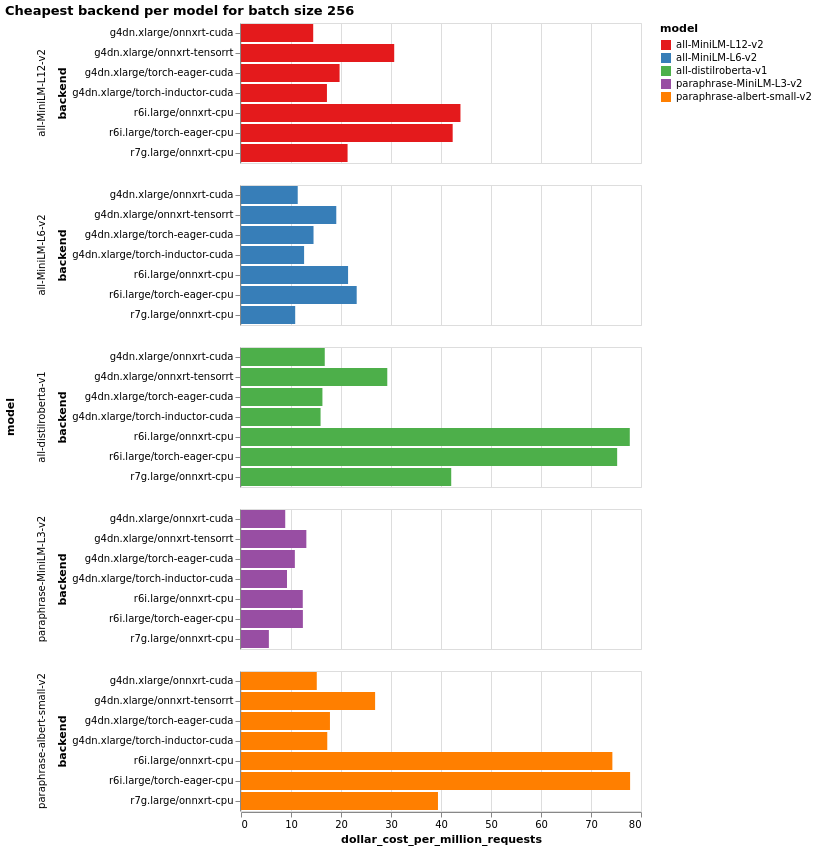

In [32]:
alt.Chart(df[df['batch_size'] == 256]).mark_bar().encode(
    y='backend',
    x='dollar_cost_per_million_requests',
    color='model',
    row='model'
).properties(title='Cheapest backend per model for batch size 256'
).configure_range(
    category={'scheme': 'set1'}
)

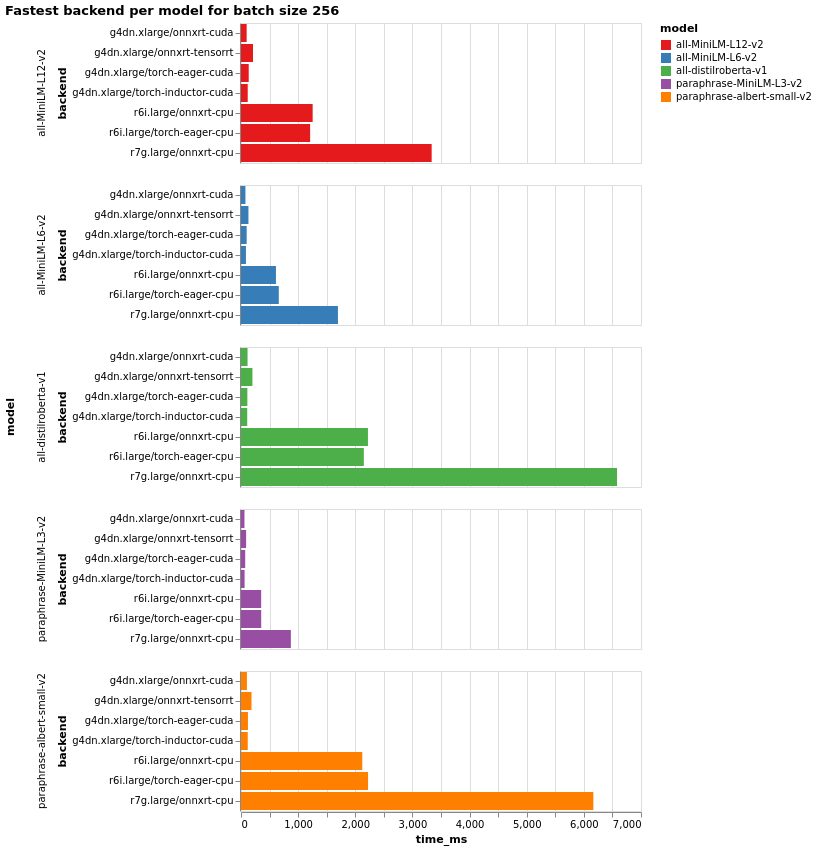

In [33]:
alt.Chart(df[df['batch_size'] == 256]).mark_bar().encode(
    y='backend',
    x='time_ms',
    color='model',
    row='model',
).properties(title='Fastest backend per model for batch size 256'
).configure_range(
    category={'scheme': 'set1'}
)

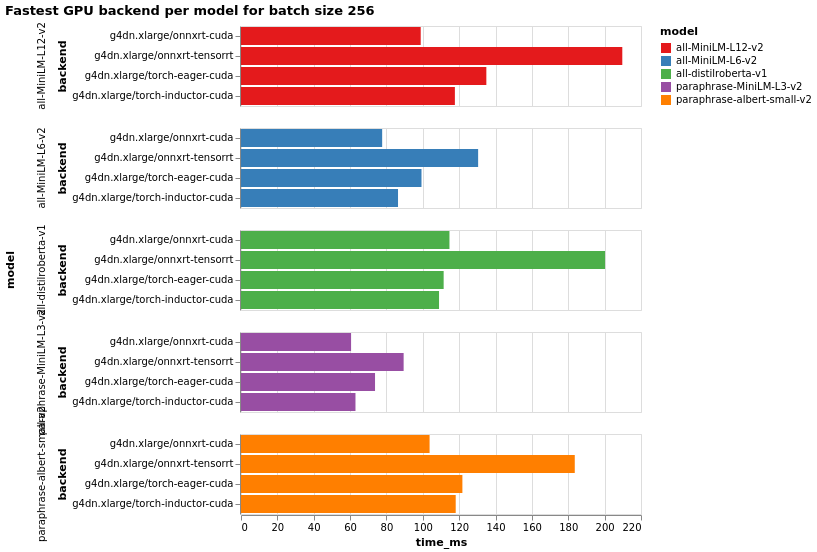

In [38]:
df_256 = df[df['batch_size'] == 256]
df_256_cpu = df_256[df_256['backend'].str.contains('cpu') == False]
alt.Chart(df_256_cpu).mark_bar().encode(
    y='backend',
    x='time_ms',
    color='model',
    row='model',
).properties(title='Fastest GPU backend per model for batch size 256'
).configure_range(
    category={'scheme': 'set1'}
)

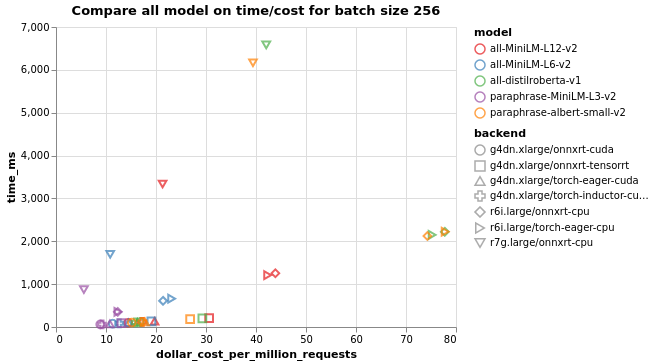

In [35]:
alt.Chart(df[df['batch_size'] == 256]).mark_point(size=60).encode(
    x='dollar_cost_per_million_requests',
    y='time_ms',
    color='model',
    shape='backend',
).properties(title='Compare all model on time/cost for batch size 256'
).configure_range(
    category={'scheme': 'set1'}
)

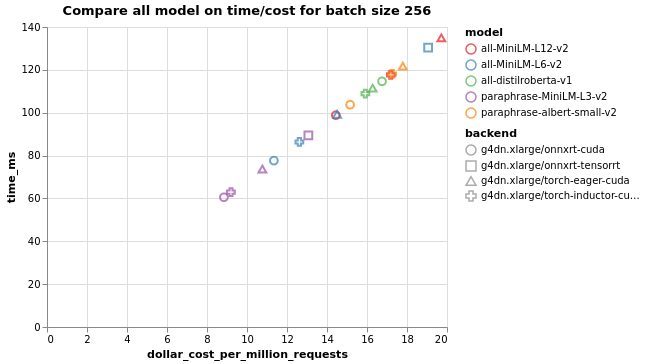

In [36]:
df_fast = df_256[df_256['dollar_cost_per_million_requests'] < 20]
df_fast = df_fast[df_fast['time_ms'] < 200]
alt.Chart(df_fast).mark_point(size=60).encode(
    x=alt.X('dollar_cost_per_million_requests', scale=alt.Scale(domain=[0, 20])),
    y='time_ms',
    color='model',
    shape='backend',
).properties(title='Compare all model on time/cost for batch size 256'
).configure_range(
    category={'scheme': 'set1'}
)

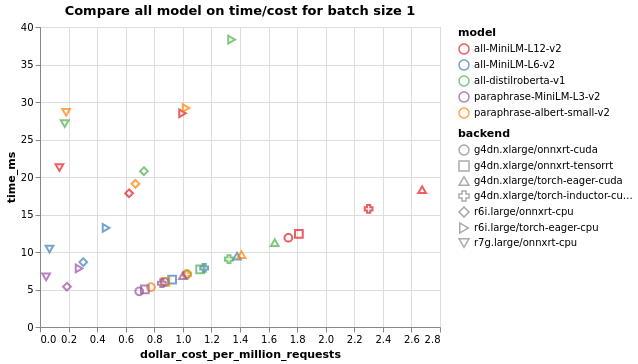

In [37]:
alt.Chart(df[df['batch_size'] == 1]).mark_point(size=60).encode(
    x='dollar_cost_per_million_requests',
    y='time_ms',
    color='model',
    shape='backend',
).properties(title='Compare all model on time/cost for batch size 1'
).configure_range(
    category={'scheme': 'set1'}
)